<a href="https://colab.research.google.com/github/guimatiolli/EV-soc-battery-ei-lstm-kf/blob/main/code_soc_lstm_kf_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EI-LSTM + Kalman Filters — SOC Estimation Pipeline**


- `artefatos/` → scalers (`x_scaler.pkl`, `y_scaler.pkl`)
- `modelos/`   → trained EI-LSTM model (`LSTM_30x1_seu.keras`)
- `data/`      → XLSX input files (DST, FUDS, US06 cycles at different temperatures)


In [ ]:
# === Environment setup: clone repo and install dependencies (Colab) ===
!git clone https://github.com/guimatiolli/EV-soc-battery-ei-lstm-kf.git
%cd EV-soc-battery-ei-lstm-kf

# Install additional Python packages (if needed)
!pip install xlsxwriter


Cloning into 'EV-soc-battery-ei-lstm-kf'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 38 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 14.39 MiB | 18.58 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/EV-soc-battery-ei-lstm-kf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 5.5 MB/s eta 0:00:00


In [ ]:
# ===== CELL 1: imports, paths, model and scalers =====
import os, time, psutil, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import load_model

# ---------- Seeds for reproducibility ----------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---------- Pastas ----------
DATA_DIR   = "data"        # where teste1_LSTM_*.xlsx and teste3_LSTM.xlsx are located
MODELS_DIR = "modelos"
ART_DIR    = "artefatos"
OUT_DIR    = "relatorios"

os.makedirs(OUT_DIR, exist_ok=True)

# ---------- Main files ----------
MODELO_OUT  = os.path.join(MODELS_DIR, "LSTM_30x1_seu.keras")
XSCALER_OUT = os.path.join(ART_DIR, "x_scaler.pkl")
YSCALER_OUT = os.path.join(ART_DIR, "y_scaler.pkl")

# ---------- Data configs ----------
TIME_STEP  = 50
INPUT_COLS = ['Current(A)', 'Voltage(V)', 'média móvel', 'Temperature']
OUTPUT_COL = 'SOC'
TEMPS      = [10, 20, 25, 30, 40]
CICLOS     = ["US06", "FUDS"]

# Calibration dataset (to estimate the UKF gamma)
DATA_TREINO = os.path.join(DATA_DIR, "teste3_LSTM.xlsx")
ABA_TREINO  = "DST"

# ======================
# Utility functions
# ======================
def carregar_df(arquivo, aba):
    df = pd.read_excel(arquivo, sheet_name=aba)
    if 'Temperature (C)_1' in df.columns:
        df = df.rename(columns={'Temperature (C)_1': 'Temperature'})
    return df

def criar_janelas_seq(X_raw, y_raw, time_step=TIME_STEP):
    X_seq, y_seq = [], []
    for i in range(len(X_raw) - time_step):
        X_seq.append(X_raw[i:i+time_step])
        y_seq.append(y_raw[i+time_step])
    return np.asarray(X_seq), np.asarray(y_seq)

def medir_tempo(func, *args, **kwargs):
    """
    Measures wall-clock time, CPU user time and memory delta (MB)
    for the call func(*args, **kwargs).
    """
    proc = psutil.Process(os.getpid())
    cpu_i = proc.cpu_times()
    mem_i = proc.memory_info().rss / (1024 * 1024)  # MB
    t0 = time.time()
    out = func(*args, **kwargs)
    t1 = time.time()
    cpu_f = proc.cpu_times()
    mem_f = proc.memory_info().rss / (1024 * 1024)  # MB
    return out, (t1 - t0), (cpu_f.user - cpu_i.user), (mem_f - mem_i)

def calcular_metricas(y_ref, y_hat):
    rmse = float(np.sqrt(mean_squared_error(y_ref, y_hat)))
    mae  = float(mean_absolute_error(y_ref, y_hat))
    maxe = float(np.max(np.abs(y_ref - y_hat)))
    r2   = float(r2_score(y_ref, y_hat))
    return rmse, mae, maxe, r2

def estimar_Q_R(y_true_inv, y_pred_inv):
    """
    Estimates process standard deviation (ΔSOC) and measurement standard deviation (LSTM residual).
    Returns (process_std, meas_std).
    """
    # R: network residuals (with light clipping against outliers)
    res = y_pred_inv - y_true_inv
    pL, pH = np.percentile(res, [0.5, 99.5])
    res_c = np.clip(res, pL, pH)
    meas_std = float(np.std(res_c, ddof=1)); meas_std = max(meas_std, 1e-6)

    # Q: variation of the true SOC (random walk model)
    d = np.diff(y_true_inv)
    if len(d) > 0:
        qL, qH = np.percentile(d, [0.5, 99.5])
        d_c = np.clip(d, qL, qH)
        process_std = float(np.std(d_c, ddof=1)); process_std = max(process_std, 1e-7)
    else:
        process_std = 1e-4

    return process_std, meas_std   # standard deviations

# ======================
# Carregar modelo e scalers
# ======================
print("➡️ Loading trained model...")
model = load_model(MODELO_OUT)
print(f"✅ Model loaded: {MODELO_OUT}")

print("\n➡️ Loading saved scalers...")
x_scaler = joblib.load(XSCALER_OUT)
y_scaler = joblib.load(YSCALER_OUT)
print(f"✅ x_scaler: {XSCALER_OUT}")
print(f"✅ y_scaler: {YSCALER_OUT}")


➡️ Loading trained model...
✅ Model loaded: modelos/LSTM_30x1_seu.keras

➡️ Loading saved scalers...
✅ x_scaler: artefatos/x_scaler.pkl
✅ y_scaler: artefatos/y_scaler.pkl


In [ ]:
# ===== CELL 2: Estimate Q_global and R_global =====

qr_all = []

print("➡️ Estimando Q/R para todos os ciclos e temperaturas...")
for ciclo in CICLOS:
    for t in TEMPS:
        arq = os.path.join(DATA_DIR, f"teste1_LSTM_{t}.xlsx")
        try:
            df_c = carregar_df(arq, ciclo)
            X_raw = x_scaler.transform(df_c[INPUT_COLS])
            y_raw = y_scaler.transform(df_c[[OUTPUT_COL]])

            X_seq, y_seq = criar_janelas_seq(X_raw, y_raw, TIME_STEP)

            # Predição da LSTM
            y_pred_scaled = model.predict(X_seq, verbose=0)
            y_pred_inv = y_scaler.inverse_transform(y_pred_scaled).ravel()
            y_true_inv = y_scaler.inverse_transform(y_seq).ravel()

            # Estima std(Q), std(R)
            qstd, rstd = estimar_Q_R(y_true_inv, y_pred_inv)
            qr_all.append({
                "Cycle": ciclo,
                "Temp": t,
                "Q_est": qstd**2,  # variância
                "R_est": rstd**2   # variância
            })
        except Exception as e:
            print(f"❌ Failed Q/R in {ciclo}@{t}°C — {e}")

df_qr_all = pd.DataFrame(qr_all).sort_values(["Cycle","Temp"]).reset_index(drop=True)
Q_global = float(np.median(df_qr_all["Q_est"])) if not df_qr_all.empty else 1e-6
R_global = float(np.percentile(df_qr_all["R_est"], 75)) if not df_qr_all.empty else 1e-4
q_global = float(np.sqrt(Q_global))
r_global = float(np.sqrt(R_global))

print("\n===== GLOBAL Q/R (fixos) =====")
with pd.option_context('display.float_format', lambda v: f"{v:.3e}"):
    print(df_qr_all.to_string(index=False))

print(f"\nQ_global = {Q_global:.3e}  (q_global = {q_global:.3e})")
print(f"R_global = {R_global:.3e}  (r_global = {r_global:.3e})")


➡️ Estimando Q/R para todos os ciclos e temperaturas...

===== GLOBAL Q/R (fixos) =====
Cycle  Temp     Q_est     R_est
 FUDS    10 5.798e-08 2.626e-04
 FUDS    20 5.800e-08 1.993e-04
 FUDS    25 5.800e-08 9.788e-04
 FUDS    30 5.806e-08 1.552e-04
 FUDS    40 5.792e-08 1.520e-04
 US06    10 3.536e-08 3.171e-04
 US06    20 3.545e-08 1.795e-04
 US06    25 3.569e-08 8.356e-04
 US06    30 3.569e-08 1.401e-04
 US06    40 3.533e-08 1.265e-04

Q_global = 4.681e-08  (q_global = 2.163e-04)
R_global = 3.035e-04  (r_global = 1.742e-02)


In [ ]:
# ===== CELL 3: Filters (KF_global, KF_adapt and UKF) + gamma =====

import numpy as np
import pandas as pd

# --- KF identidade com Q,R fixos globais (entrada em desvio-padrão) ---
def kf_identity_fixed(y_observed, process_std, meas_std, P0=1.0, clip=True):
    """
    Modelo:
        x_{k+1} = x_k + w_k,   w ~ N(0,Q)
        z_k     = x_k + v_k,   v ~ N(0,R)

    Parâmetros:
        process_std : desvio-padrão do ruído de processo (sqrt(Q))
        meas_std    : desvio-padrão do ruído de medição (sqrt(R))
        P0          : variância inicial
        clip        : se True, limita x em [0,1]
    """
    z = np.asarray(y_observed, float).ravel()
    if z.size == 0:
        return np.array([])
    Q = float(process_std**2)
    R = float(meas_std**2)

    x = float(z[0])   # inicializa com a primeira saída da LSTM
    P = float(P0)
    out = [x]

    for k in range(1, len(z)):
        # Predição
        P = P + Q

        # Inovação
        inov = float(z[k]) - x
        S = P + R
        K = P / max(S, 1e-12)

        # Atualização
        x = x + K * inov
        P = (1.0 - K) * P

        if clip:
            x = float(np.clip(x, 0.0, 1.0))
        out.append(x)

    return np.asarray(out, float)


# --- KF identidade com R adaptativo baseado na inovação (entrada em variância) ---
# --- KF identidade com R adaptativo baseado na inovação (entrada em DESVIO-PADRÃO) ---
def kf_identity_adapt_R(
    y_observed,
    process_std,      # sqrt(Q)
    meas_std0,        # sqrt(R0)
    P0=1.0,
    clip=True,
    window_size=200,
    alpha=0.01,       # igual ao código grande
    gamma_min=0.2,
    gamma_max=5.0,
    R_min_factor=0.1,
    R_max_factor=10.0
):
    """
    KF identidade (random walk) com R adaptativo baseado na estatística da inovação,
    espelhando o comportamento do 'código grande'.
    """
    z = np.asarray(y_observed, float).ravel()
    if z.size == 0:
        return np.array([])

    # std -> variância
    Q  = float(process_std**2)
    R0 = float(meas_std0**2)

    # limites relativos de R
    R_min = R_min_factor * R0
    R_max = R_max_factor * R0

    # inicialização
    x = float(z[0])
    P = float(P0)
    R = float(R0)

    out = [x]
    innovations = []  # janela deslizante das inovações

    for k in range(1, z.size):
        # Predict
        P = P + Q

        # Inovação
        inov = float(z[k]) - x
        innovations.append(inov)
        if len(innovations) > window_size:
            innovations.pop(0)

        # Adaptação de R usando var( inovação ) normalizada por S_pred
        if len(innovations) >= max(10, int(0.1 * window_size)):
            sigma2_nu = float(np.var(innovations, ddof=1))
            S_pred = P + R
            if S_pred > 1e-12 and sigma2_nu > 0.0:
                gamma = sigma2_nu / S_pred
                gamma = float(np.clip(gamma, gamma_min, gamma_max))
                # atualização multiplicativa suavizada
                R = (1.0 - alpha) * R + alpha * (gamma * R)
                R = float(np.clip(R, R_min, R_max))

        # Update
        S = P + R
        K = P / max(S, 1e-12)
        x = x + K * inov
        P = (1.0 - K) * P

        if clip:
            x = float(np.clip(x, 0.0, 1.0))
        out.append(x)

    return np.asarray(out, float)


# --- Estimar gamma (γ) a partir do DST ---
def estimar_gamma_soc(arquivo, aba):
    """
    Ajusta ΔSOC ≈ γ * I por mínimos quadrados,
    usando dados de laboratório (DST).

    Retorna:
        gamma em unidades de (ΔSOC / A), assumindo passo de tempo constante.
    """
    df = pd.read_excel(arquivo, sheet_name=aba)
    I   = df['Current(A)'].values.astype(float)
    soc = df['SOC'].values.astype(float)

    d_soc = np.diff(soc)
    I_mid = I[1:]

    denom = float(np.dot(I_mid, I_mid))
    if denom <= 0.0:
        return 0.0

    gamma = float(np.dot(I_mid, d_soc) / denom)
    return gamma


# --- UKF 1D para SOC (modelo físico simples) ---
def ukf_soc(current, z_meas, gamma, Q, R,
            x0=None, P0=1.0,
            alpha=1e-3, beta=2.0, kappa=0.0,
            clip=True):
    """
    Filtro de Kalman não linear (UKF) 1D para SOC.

    Estado:
        x_k = SOC_k

    Modelo de processo:
        x_{k+1} = x_k + gamma * I_k + w_k,   w_k ~ N(0, Q)

    Modelo de medição:
        z_k = x_k + v_k,                     v_k ~ N(0, R)

    Parâmetros:
        current : corrente I_k (mesma dimensão de z_meas)
        z_meas  : medições (saída da LSTM, SOC real)
        gamma   : coeficiente de conversão corrente → ΔSOC
        Q       : variância do ruído de processo
        R       : variância do ruído de medição
    """
    z = np.asarray(z_meas, float).ravel()
    I = np.asarray(current, float).ravel()
    N = z.size
    if N == 0:
        return np.array([])

    # Dimensão do estado
    n = 1

    # Parâmetros do UKF (Julier & Uhlmann)
    lam = alpha**2 * (n + kappa) - n
    c = n + lam
    Wm0 = lam / c
    Wc0 = Wm0 + (1.0 - alpha**2 + beta)
    Wi = 1.0 / (2.0 * c)

    # Inicialização
    x = float(z[0]) if x0 is None else float(x0)
    P = float(P0)

    out = np.zeros(N, float)
    out[0] = np.clip(x, 0.0, 1.0) if clip else x

    for k in range(1, N):
        Ik = float(I[k])

        # Sigma points em torno de x,P
        sqrtP = np.sqrt(max(c * P, 0.0))
        chi0 = x
        chi1 = x + sqrtP
        chi2 = x - sqrtP

        # Passo de processo: f(x) = x + gamma * I_k
        f0 = chi0 + gamma * Ik
        f1 = chi1 + gamma * Ik
        f2 = chi2 + gamma * Ik

        # Predição do estado
        x_pred = Wm0 * f0 + Wi * (f1 + f2)
        P_pred = (Wc0 * (f0 - x_pred)**2 +
                  Wi * ((f1 - x_pred)**2 + (f2 - x_pred)**2) +
                  Q)

        # Predição da medição (h(x) = x)
        z0 = f0
        z1 = f1
        z2 = f2
        z_pred = Wm0 * z0 + Wi * (z1 + z2)
        S = (Wc0 * (z0 - z_pred)**2 +
             Wi * ((z1 - z_pred)**2 + (z2 - z_pred)**2) +
             R)

        # Covariância cruzada
        Pxz = (Wc0 * (f0 - x_pred) * (z0 - z_pred) +
               Wi * ((f1 - x_pred) * (z1 - z_pred) +
                     (f2 - x_pred) * (z2 - z_pred)))

        # Ganho de Kalman
        K = Pxz / max(S, 1e-12)

        # Atualização
        zk = float(z[k])
        x = x_pred + K * (zk - z_pred)
        P = P_pred - K * S * K

        if clip:
            x = float(np.clip(x, 0.0, 1.0))
        out[k] = x

    return out


# ---- Estimar gamma a partir do DST ----
print("➡️ Estimando gamma (γ) a partir do DST...")
gamma = estimar_gamma_soc(DATA_TREINO, ABA_TREINO)
print(f"Estimativa de gamma (ΔSOC ≈ γ * I): {gamma:.3e}")

# Hiperparâmetros do KF adaptativo (os "originais" que você usou)
ADAPT_ALPHA       = 0.05
ADAPT_RMIN_FACTOR = 0.1
ADAPT_RMAX_FACTOR = 10.0


➡️ Estimando gamma (γ) a partir do DST...
Estimativa de gamma (ΔSOC ≈ γ * I): 2.538e-04


In [ ]:
# ===== CELL 4: Main loop — metrics and processing =====

rows_metrics = []
rows_proc    = []

for ciclo in CICLOS:
    for t in TEMPS:
        arq = os.path.join(DATA_DIR, f"teste1_LSTM_{t}.xlsx")
        try:
            df_c = carregar_df(arq, ciclo)

            # Input/output scaling
            X_raw = x_scaler.transform(df_c[INPUT_COLS])
            y_raw = y_scaler.transform(df_c[[OUTPUT_COL]])

            # Janelas
            X_seq, y_seq = criar_janelas_seq(X_raw, y_raw, TIME_STEP)

            # Corrente alinhada com y_seq (para UKF)
            I_full = df_c['Current(A)'].values.astype(float)
            I_seq  = I_full[TIME_STEP:TIME_STEP + len(y_seq)]

            # ---------- LSTM prediction (raw) ----------
            (y_pred_scaled), t_pred, cpu_pred, mem_pred = medir_tempo(
                model.predict, X_seq, 0
            )
            y_pred_inv = y_scaler.inverse_transform(y_pred_scaled).ravel()
            y_true_inv = y_scaler.inverse_transform(y_seq).ravel()
            N = len(y_true_inv)

            # ---------- KF GLOBAL FIXO ----------
            (y_kf_global), t_kfG, cpu_kfG, mem_kfG = medir_tempo(
                kf_identity_fixed,
                y_pred_inv,
                q_global,
                r_global,
                1.0,
                True
            )

            # ---------- KF ADAPTATIVO (R_k) ----------
            (y_kf_adapt), t_kfA, cpu_kfA, mem_kfA = medir_tempo(
                kf_identity_adapt_R,
                y_pred_inv,
                q_global,
                r_global,
                1.0,               # P0
                True,              # clip
                200,               # window_size
                0.01,              # alpha
                0.2,               # gamma_min
                5.0,               # gamma_max
                0.1,               # R_min_factor
                10.0
            )

            # ---------- UKF ----------
            (y_ukf), t_ukf, cpu_ukf, mem_ukf = medir_tempo(
                ukf_soc,
                I_seq,
                y_pred_inv,
                gamma,
                Q_global,
                R_global,
                None,
                1.0,
                1e-3,
                2.0,
                0.0,
                True
            )

            # =======================
            # Performance metrics
            # =======================
            rmse_raw, mae_raw, maxe_raw, r2_raw = calcular_metricas(y_true_inv, y_pred_inv)
            rmse_kfG, mae_kfG, maxe_kfG, r2_kfG = calcular_metricas(y_true_inv, y_kf_global)
            rmse_kfA, mae_kfA, maxe_kfA, r2_kfA = calcular_metricas(y_true_inv, y_kf_adapt)
            rmse_ukf, mae_ukf, maxe_ukf, r2_ukf = calcular_metricas(y_true_inv, y_ukf)

            rows_metrics.append({
                "Cycle": ciclo,
                "Temp": t,
                "RMSE_Raw": rmse_raw,
                "RMSE_KF_global": rmse_kfG,
                "RMSE_KF_adapt": rmse_kfA,
                "RMSE_UKF": rmse_ukf,
                "MAE_Raw": mae_raw,
                "MAE_KF_global": mae_kfG,
                "MAE_KF_adapt": mae_kfA,
                "MAE_UKF": mae_ukf,
                "MAXE_Raw": maxe_raw,
                "MAXE_KF_global": maxe_kfG,
                "MAXE_KF_adapt": maxe_kfA,
                "MAXE_UKF": maxe_ukf,
                "R2_Raw": r2_raw,
                "R2_KF_global": r2_kfG,
                "R2_KF_adapt": r2_kfA,
                "R2_UKF": r2_ukf,
            })

            # =======================
            # Computational metrics
            # =======================
            rows_proc.append({
                "Cycle": ciclo,
                "Temp": t,
                "File": os.path.basename(arq),
                "N": N,
                # LSTM
                "Pred_Time_s": t_pred,
                "Pred_CPU_s": cpu_pred,
                "Pred_MemDelta_MB": mem_pred,
                "Pred_Throughput_sps": (N / t_pred) if t_pred > 0 else np.nan,
                # KF global
                "KF_Global_Time_s": t_kfG,
                "KF_Global_CPU_s": cpu_kfG,
                "KF_Global_MemDelta_MB": mem_kfG,
                "KF_Global_Throughput_sps": (N / t_kfG) if t_kfG > 0 else np.nan,
                # KF adapt
                "KF_Adapt_Time_s": t_kfA,
                "KF_Adapt_CPU_s": cpu_kfA,
                "KF_Adapt_MemDelta_MB": mem_kfA,
                "KF_Adapt_Throughput_sps": (N / t_kfA) if t_kfA > 0 else np.nan,
                # UKF
                "UKF_Time_s": t_ukf,
                "UKF_CPU_s": cpu_ukf,
                "UKF_MemDelta_MB": mem_ukf,
                "UKF_Throughput_sps": (N / t_ukf) if t_ukf > 0 else np.nan,
            })

        except Exception as e:
            print(f"❌ Failed {ciclo}@{t}°C — {e}")

df_metrics = pd.DataFrame(rows_metrics).sort_values(["Cycle","Temp"]).reset_index(drop=True)
df_proc    = pd.DataFrame(rows_proc).sort_values(["Cycle","Temp"]).reset_index(drop=True)
print("✅ Main loop completed.")


205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
✅ Main loop completed.


In [ ]:
# ===== CELL 5: Final tables and saving =====

print("\n===== METRICS — RAW vs KF Global vs KF Adapt vs UKF (FUDS & US06) =====")
with pd.option_context('display.float_format', lambda v: f"{v:.6f}" if isinstance(v,float) else str(v)):
    print(df_metrics.to_string(index=False))

print("\n===== PROCESSING — Time, CPU, Memory, Throughput (FUDS & US06) =====")
cols_proc = [
    "Cycle","Temp","File","N",
    "Pred_Time_s","Pred_CPU_s","Pred_MemDelta_MB","Pred_Throughput_sps",
    "KF_Global_Time_s","KF_Global_CPU_s","KF_Global_MemDelta_MB","KF_Global_Throughput_sps",
    "KF_Adapt_Time_s","KF_Adapt_CPU_s","KF_Adapt_MemDelta_MB","KF_Adapt_Throughput_sps",
    "UKF_Time_s","UKF_CPU_s","UKF_MemDelta_MB","UKF_Throughput_sps",
]
with pd.option_context('display.float_format', lambda v: f"{v:.6f}" if isinstance(v,float) else str(v)):
    print(df_proc[cols_proc].to_string(index=False))

# ----- Salvar em Excel -----
out_xlsx = os.path.join(OUT_DIR, "Summary_KF_global_adapt_UKF_FUDS_US06.xlsx")
with pd.ExcelWriter(out_xlsx, engine="xlsxwriter") as wr:
    df_qr_all.to_excel(wr, sheet_name="Q_R_global_estimated", index=False)
    df_metrics.to_excel(wr, sheet_name="Metrics", index=False)
    df_proc.to_excel(wr, sheet_name="Processing", index=False)

print(f"\n💾 File saved to: {out_xlsx}")



===== METRICS — RAW vs KF Global vs KF Adapt vs UKF (FUDS & US06) =====
Cycle  Temp  RMSE_Raw  RMSE_KF_global  RMSE_KF_adapt  RMSE_UKF  MAE_Raw  MAE_KF_global  MAE_KF_adapt  MAE_UKF  MAXE_Raw  MAXE_KF_global  MAXE_KF_adapt  MAXE_UKF   R2_Raw  R2_KF_global  R2_KF_adapt   R2_UKF
 FUDS    10  0.016500        0.012949       0.011661  0.008184 0.011869       0.010125      0.008806 0.006229  0.067868        0.039963       0.039274  0.036879 0.995423      0.997181     0.997714 0.998874
 FUDS    20  0.014734        0.011158       0.009680  0.007025 0.010779       0.008241      0.007438 0.005739  0.067673        0.037883       0.035326  0.027600 0.996340      0.997901     0.998420 0.999168
 FUDS    25  0.032043        0.013956       0.016296  0.014203 0.023977       0.010641      0.012847 0.010735  0.126582        0.049595       0.043515  0.062365 0.982760      0.996730     0.995541 0.996613
 FUDS    30  0.013981        0.009817       0.009145  0.008016 0.010778       0.007178      0.007236 0.

# **Plots**


=== US06 @ 10°C ===
Média dos resíduos = -4.6119e-03
Desvio padrão dos resíduos = 1.7922e-02
N = 6550


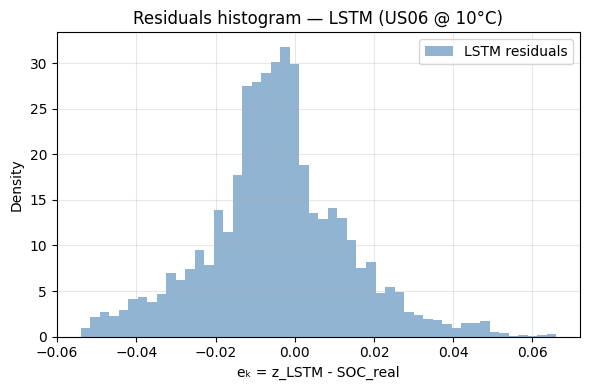


=== US06 @ 20°C ===
Média dos resíduos = -5.1342e-03
Desvio padrão dos resíduos = 1.3631e-02
N = 6558


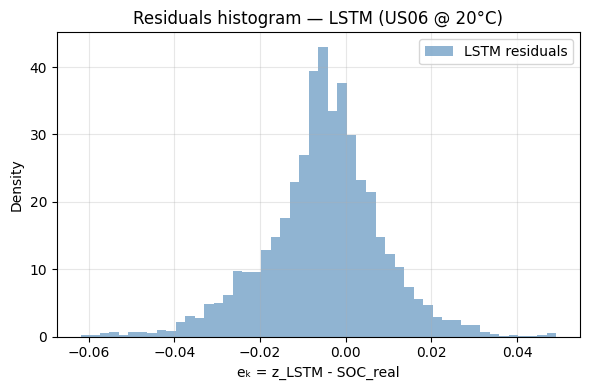


=== US06 @ 25°C ===
Média dos resíduos = -1.1058e-02
Desvio padrão dos resíduos = 2.9240e-02
N = 6548


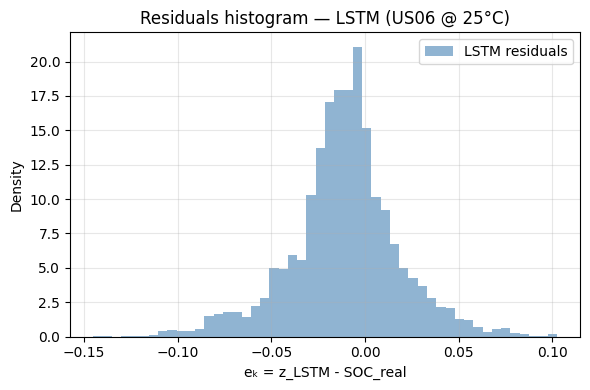


=== US06 @ 30°C ===
Média dos resíduos = -4.3402e-03
Desvio padrão dos resíduos = 1.2034e-02
N = 6549


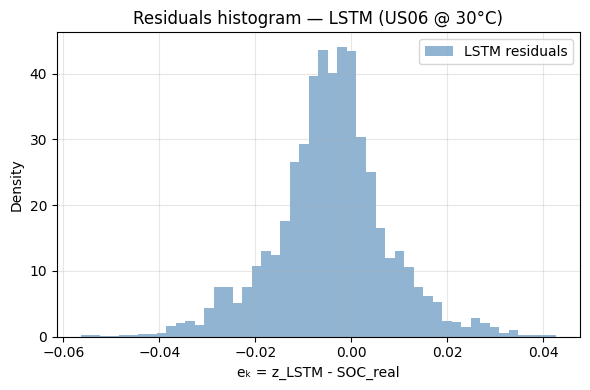


=== US06 @ 40°C ===
Média dos resíduos = -6.8536e-03
Desvio padrão dos resíduos = 1.1450e-02
N = 6552


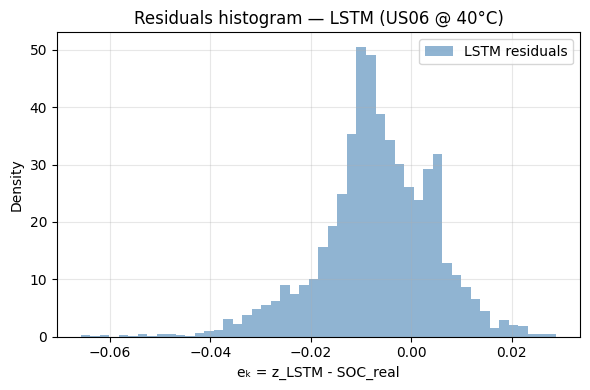


=== FUDS @ 10°C ===
Média dos resíduos = -7.2345e-04
Desvio padrão dos resíduos = 1.6486e-02
N = 6799


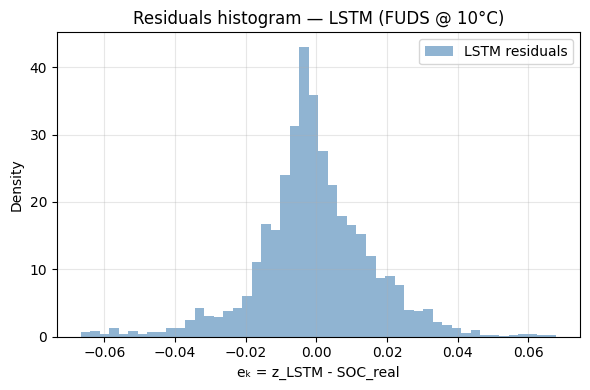


=== FUDS @ 20°C ===
Média dos resíduos = -2.8323e-03
Desvio padrão dos resíduos = 1.4460e-02
N = 6799


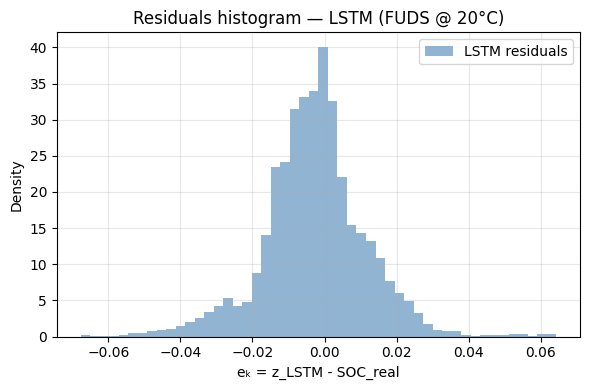


=== FUDS @ 25°C ===
Média dos resíduos = -4.9811e-03
Desvio padrão dos resíduos = 3.1655e-02
N = 6791


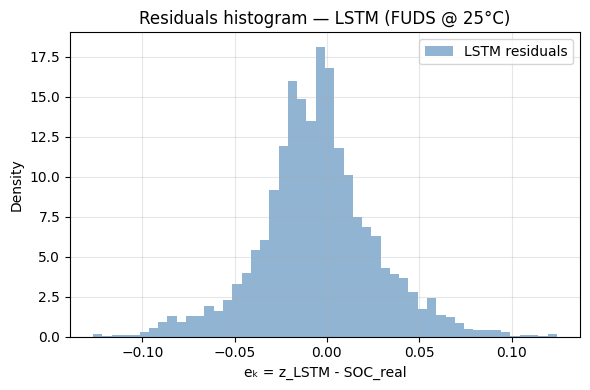


=== FUDS @ 30°C ===
Média dos resíduos = -5.6262e-03
Desvio padrão dos resíduos = 1.2800e-02
N = 6791


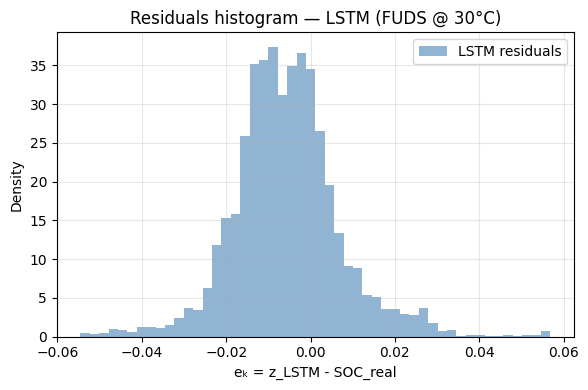


=== FUDS @ 40°C ===
Média dos resíduos = -8.5951e-03
Desvio padrão dos resíduos = 1.2456e-02
N = 6798


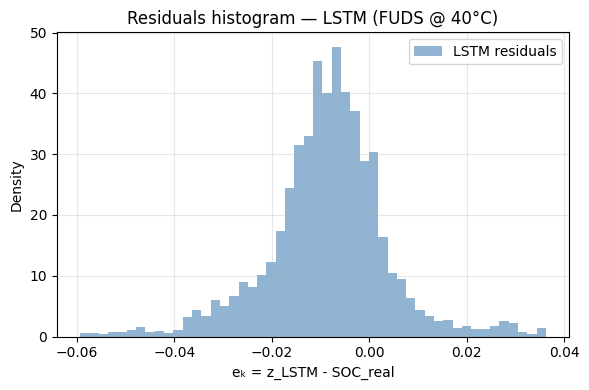

In [ ]:
# === HISTOGRAM OF LSTM RESIDUALS (without Gaussian curve) ===
import numpy as np
import matplotlib.pyplot as plt
import os

BINS = 50  # number of histogram bins

for ciclo in CICLOS:
    for temp in TEMPS:
        arq = os.path.join(DATA_DIR, f"teste1_LSTM_{temp}.xlsx")
        try:
            # 1) Carrega dados e prepara janelas
            df = carregar_df(arq, ciclo)
            X_raw = x_scaler.transform(df[INPUT_COLS])
            y_raw = y_scaler.transform(df[[OUTPUT_COL]])
            X_seq, y_seq = criar_janelas_seq(X_raw, y_raw, TIME_STEP)

            # 2) Predição da LSTM
            y_pred_scaled = model.predict(X_seq, verbose=0)
            y_pred_inv = y_scaler.inverse_transform(y_pred_scaled).ravel()
            y_true_inv = y_scaler.inverse_transform(y_seq).ravel()

            # 3) Resíduos
            e = y_pred_inv - y_true_inv
            mu = float(np.mean(e))
            sigma = float(np.std(e, ddof=1))

            print(f"\n=== {ciclo} @ {temp}°C ===")
            print(f"Média dos resíduos = {mu:.4e}")
            print(f"Desvio padrão dos resíduos = {sigma:.4e}")
            print(f"N = {len(e)}")

            # 4) Histograma normalizado
            plt.figure(figsize=(6, 4))
            plt.hist(e, bins=BINS, density=True, alpha=0.6, color='steelblue', label="LSTM residuals")
            plt.title(f"Residuals histogram — LSTM ({ciclo} @ {temp}°C)")
            plt.xlabel("eₖ = z_LSTM - SOC_real")
            plt.ylabel("Density")
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()

        except Exception as exc:
            print(f"❌ Failed in {ciclo}@{temp}°C — {exc}")


In [ ]:
# === SUMMARY TABLE OF LSTM RESIDUALS (μ, σ, N) ===
import pandas as pd
import numpy as np
import os

rows = []

for ciclo in CICLOS:
    for temp in TEMPS:
        arq = os.path.join(DATA_DIR, f"teste1_LSTM_{temp}.xlsx")
        try:
            # Carrega e prepara janelas
            df = carregar_df(arq, ciclo)
            X_raw = x_scaler.transform(df[INPUT_COLS])
            y_raw = y_scaler.transform(df[[OUTPUT_COL]])
            X_seq, y_seq = criar_janelas_seq(X_raw, y_raw, TIME_STEP)

            # Predição e inversão
            y_pred_scaled = model.predict(X_seq, verbose=0)
            y_pred_inv = y_scaler.inverse_transform(y_pred_scaled).ravel()
            y_true_inv = y_scaler.inverse_transform(y_seq).ravel()

            # Resíduos
            e = y_pred_inv - y_true_inv
            mu = float(np.mean(e))
            sigma = float(np.std(e, ddof=1))
            N = len(e)

            rows.append({
                "Cycle": ciclo,
                "Temp (°C)": temp,
                "Mean (μ)": mu,
                "Std (σ)": sigma,
                "N": N
            })

        except Exception as exc:
            print(f"❌ Failed in {ciclo}@{temp}°C — {exc}")

# Monta DataFrame final
df_lstm_resid = pd.DataFrame(rows).sort_values(["Cycle", "Temp (°C)"]).reset_index(drop=True)

# Exibe com formatação científica
with pd.option_context('display.float_format', lambda v: f"{v:.4e}" if isinstance(v, float) else f"{v}"):
    print("\n===== Statistics of LSTM residuals =====")
    print(df_lstm_resid.to_string(index=False))



===== Statistics of LSTM residuals =====
Cycle  Temp (°C)    Mean (μ)    Std (σ)    N
 FUDS         10 -7.2345e-04 1.6486e-02 6799
 FUDS         20 -2.8323e-03 1.4460e-02 6799
 FUDS         25 -4.9811e-03 3.1655e-02 6791
 FUDS         30 -5.6262e-03 1.2800e-02 6791
 FUDS         40 -8.5951e-03 1.2456e-02 6798
 US06         10 -4.6119e-03 1.7922e-02 6550
 US06         20 -5.1342e-03 1.3631e-02 6558
 US06         25 -1.1058e-02 2.9240e-02 6548
 US06         30 -4.3402e-03 1.2034e-02 6549
 US06         40 -6.8536e-03 1.1450e-02 6552



=== US06 @ 10°C — ΔSOC ===
ΔSOC: média = -1.3377e-04, desvio padrão = 1.9015e-04, N = 6549


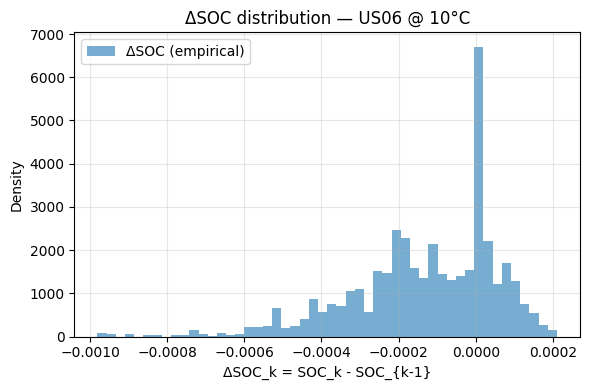


=== US06 @ 20°C — ΔSOC ===
ΔSOC: média = -1.3366e-04, desvio padrão = 1.9017e-04, N = 6557


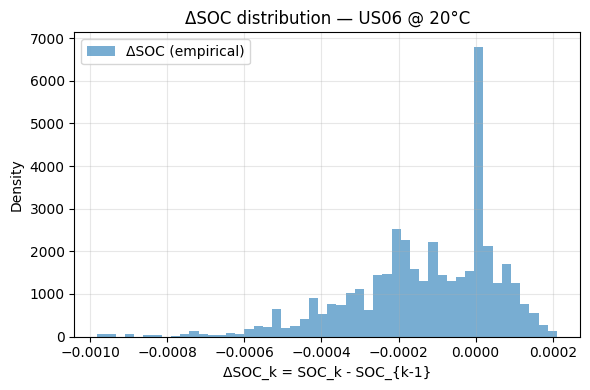


=== US06 @ 25°C — ΔSOC ===
ΔSOC: média = -1.3406e-04, desvio padrão = 1.9081e-04, N = 6547


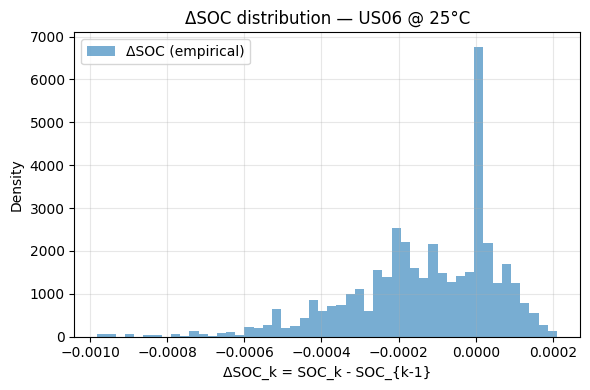


=== US06 @ 30°C — ΔSOC ===
ΔSOC: média = -1.3394e-04, desvio padrão = 1.9082e-04, N = 6548


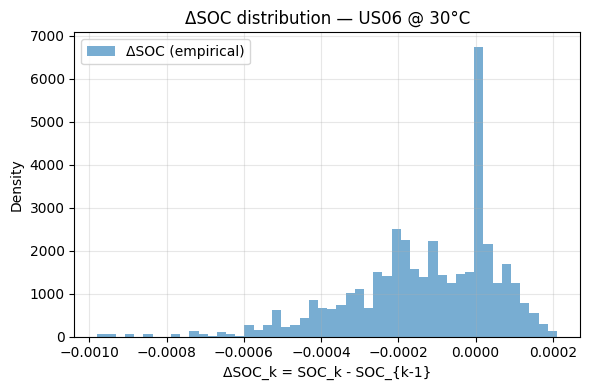


=== US06 @ 40°C — ΔSOC ===
ΔSOC: média = -1.3336e-04, desvio padrão = 1.9010e-04, N = 6551


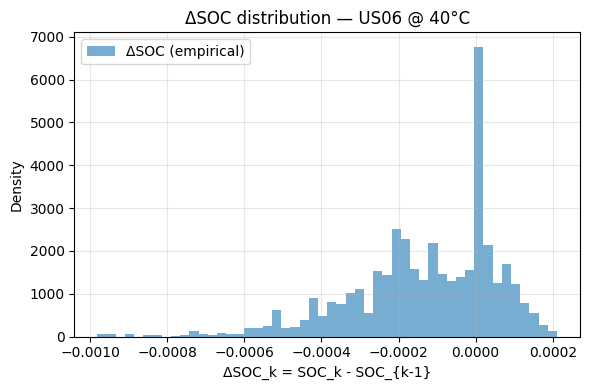


=== FUDS @ 10°C — ΔSOC ===
ΔSOC: média = -1.2438e-04, desvio padrão = 2.4133e-04, N = 6798


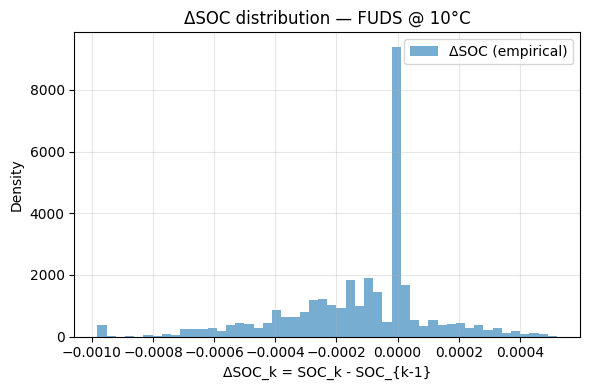


=== FUDS @ 20°C — ΔSOC ===
ΔSOC: média = -1.2420e-04, desvio padrão = 2.4136e-04, N = 6798


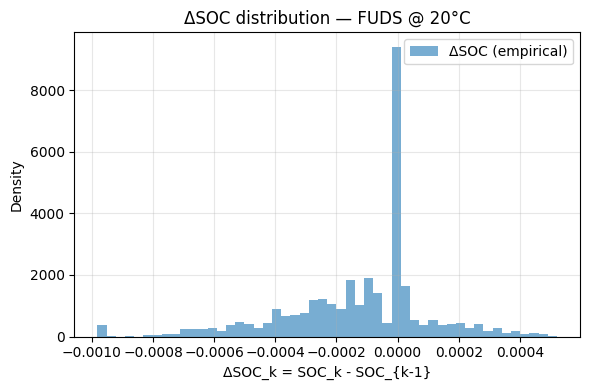


=== FUDS @ 25°C — ΔSOC ===
ΔSOC: média = -1.2445e-04, desvio padrão = 2.4141e-04, N = 6790


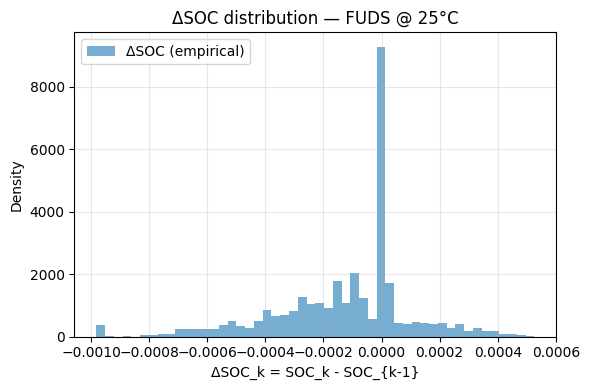


=== FUDS @ 30°C — ΔSOC ===
ΔSOC: média = -1.2407e-04, desvio padrão = 2.4157e-04, N = 6790


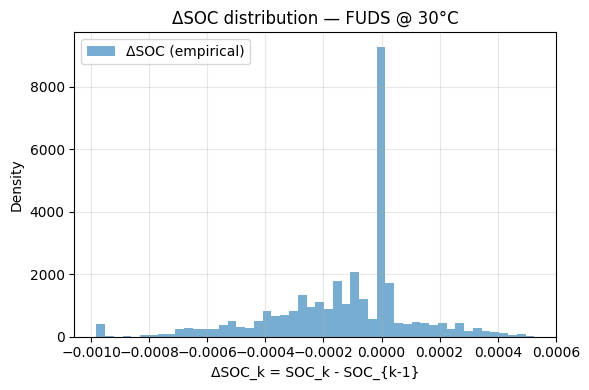


=== FUDS @ 40°C — ΔSOC ===
ΔSOC: média = -1.2464e-04, desvio padrão = 2.4123e-04, N = 6797


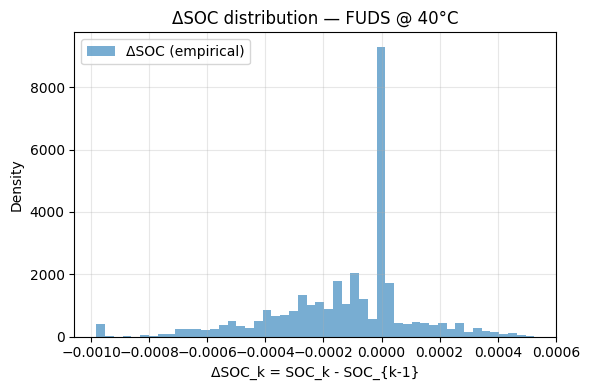

In [ ]:
# === ΔSOC DISTRIBUTION (without Gaussian curve) ===
import numpy as np
import matplotlib.pyplot as plt
import os

BINS = 50  # number of histogram bins

for ciclo in CICLOS:
    for temp in TEMPS:
        arq = os.path.join(DATA_DIR, f"teste1_LSTM_{temp}.xlsx")
        try:
            # 1) Carrega dados e prepara janelas
            df = carregar_df(arq, ciclo)
            X_raw = x_scaler.transform(df[INPUT_COLS])
            y_raw = y_scaler.transform(df[[OUTPUT_COL]])
            X_seq, y_seq = criar_janelas_seq(X_raw, y_raw, TIME_STEP)

            # 2) SOC real (invertido)
            y_true_inv = y_scaler.inverse_transform(y_seq).ravel()

            if len(y_true_inv) < 2:
                print(f"⚠ Poucos pontos para ΔSOC em {ciclo}@{temp}°C")
                continue

            # 3) ΔSOC
            dSOC = np.diff(y_true_inv)
            mu = float(np.mean(dSOC))
            sigma = float(np.std(dSOC, ddof=1))

            print(f"\n=== {ciclo} @ {temp}°C — ΔSOC ===")
            print(f"ΔSOC: média = {mu:.4e}, desvio padrão = {sigma:.4e}, N = {len(dSOC)}")

            # 4) Histograma normalizado (sem curva gaussiana)
            plt.figure(figsize=(6,4))
            plt.hist(dSOC, bins=BINS, density=True, alpha=0.6, label="ΔSOC (empirical)")
            plt.title(f"ΔSOC distribution — {ciclo} @ {temp}°C")
            plt.xlabel("ΔSOC_k = SOC_k - SOC_{k-1}")
            plt.ylabel("Density")
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()

        except Exception as exc:
            print(f"❌ Failed in ΔSOC de {ciclo}@{temp}°C — {exc}")


# **Plots complete models**

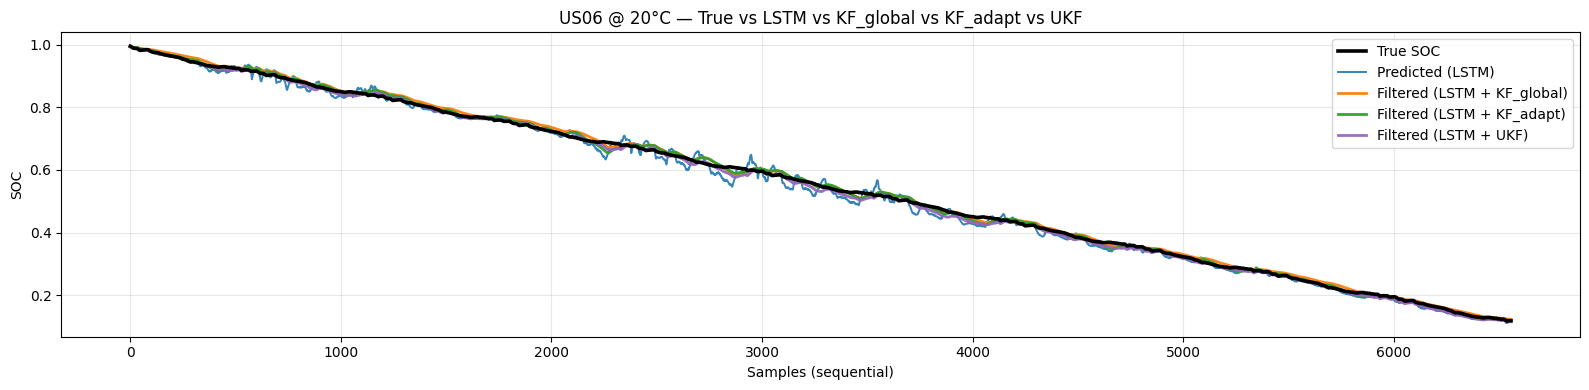

In [ ]:
# === SOC vs Samples — US06 @ 20°C (True, LSTM, KF_global, KF_adapt, UKF opcional) ===
import numpy as np
import matplotlib.pyplot as plt
import os

# ----- Test parameters -----
ciclo = "US06"
temp  = 20

# ----- Distinct colors -----
clr_true   = "black"
clr_lstm   = "#1f77b4"   # azul
clr_kfg    = "#ff7f0e"   # laranja
clr_kfa    = "#2ca02c"   # verde
clr_ukf    = "#9467bd"   # roxo

try:
    # 1) Carrega dados e cria janelas (NOMES DO CÓDIGO ENXUTO)
    arq = os.path.join(DATA_DIR, f"teste1_LSTM_{temp}.xlsx")
    df  = carregar_df(arq, ciclo)

    X_raw = x_scaler.transform(df[INPUT_COLS])
    y_raw = y_scaler.transform(df[[OUTPUT_COL]])
    X_seq, y_seq = criar_janelas_seq(X_raw, y_raw, TIME_STEP)

    # 2) Predição LSTM e inversão
    y_pred_scaled = model.predict(X_seq, verbose=0)
    y_pred_inv    = y_scaler.inverse_transform(y_pred_scaled).ravel()
    y_true_inv    = y_scaler.inverse_transform(y_seq).ravel()

    # 3) Corrente alinhada (para UKF)
    I_full = df['Current(A)'].values.astype(float)
    I_seq  = I_full[TIME_STEP:TIME_STEP + len(y_true_inv)]

    # 4) STD globais Q/R (do seu notebook)
    if "q_global" not in globals() or "r_global" not in globals():
        raise ValueError("Defina q_global e r_global (standard deviations) no escopo antes de rodar este bloco.")
    q_std = float(q_global)
    r_std = float(r_global)

    # 5) KF Global (usa sua função kf_identity_fixed)
    if "kf_identity_fixed" not in globals():
        raise NameError("Função kf_identity_fixed não encontrada no escopo do código enxuto.")
    y_kf_global = kf_identity_fixed(y_pred_inv, q_std, r_std, P0=1.0, clip=True)

    # 6) KF Adaptativo (usa sua função kf_identity_adapt_R)
    if "kf_identity_adapt_R" not in globals():
        raise NameError("Function kf_identity_adapt_R not found in the scope of the compact code.")
    # Usa hiperparâmetros do seu notebook se existirem; senão, defaults seguros
    adapt_alpha       = ADAPT_ALPHA        if "ADAPT_ALPHA"        in globals() else 0.01
    adapt_rmin_factor = ADAPT_RMIN_FACTOR  if "ADAPT_RMIN_FACTOR"  in globals() else 0.1
    adapt_rmax_factor = ADAPT_RMAX_FACTOR  if "ADAPT_RMAX_FACTOR"  in globals() else 10.0

    y_kf_adapt = kf_identity_adapt_R(
        y_pred_inv,
        q_std,
        r_std,
        alpha=adapt_alpha,
        R_min_factor=adapt_rmin_factor,
        R_max_factor=adapt_rmax_factor,
        P0=1.0,
        clip=True
    )

    # 7) UKF (opcional) — roda só se existir ukf_soc
    y_ukf = None
    if "ukf_soc" in globals():
        # Usa 'gamma' do seu ambiente se existir; senão estima por LS simples
        if "gamma" in globals():
            gamma_val = float(gamma)
        else:
            # estima gamma tal que ΔSOC ≈ gamma * I
            y = y_true_inv.astype(float)
            d_soc = np.diff(y)
            I_mid = I_seq[1:][:len(d_soc)]
            denom = float(np.dot(I_mid, I_mid))
            gamma_val = float(np.dot(I_mid, d_soc) / denom) if denom > 0 else 0.0

        Q = float(q_std**2)
        R = float(r_std**2)
        y_ukf = ukf_soc(current=I_seq, z_meas=y_pred_inv, gamma=gamma_val, Q=Q, R=R)

    # 8) Plot
    n = len(y_true_inv)
    x = np.arange(n)

    plt.figure(figsize=(16, 4))
    plt.plot(x, y_true_inv,           label="True SOC",                color=clr_true, linewidth=2.6, zorder=5)
    plt.plot(x, y_pred_inv,           label="Predicted (LSTM)",        color=clr_lstm, linewidth=1.4, alpha=0.9)
    plt.plot(x, y_kf_global,          label="Filtered (LSTM + KF_global)", color=clr_kfg, linewidth=2.0, alpha=0.95)
    plt.plot(x, y_kf_adapt,           label="Filtered (LSTM + KF_adapt)",  color=clr_kfa, linewidth=2.0, alpha=0.95)
    if y_ukf is not None:
        plt.plot(x, y_ukf,            label="Filtered (LSTM + UKF)",   color=clr_ukf, linewidth=2.0, alpha=0.95)

    plt.title(f"{ciclo} @ {temp}°C — True vs LSTM vs KF_global vs KF_adapt" + (" vs UKF" if y_ukf is not None else ""))
    plt.xlabel("Samples (sequential)")
    plt.ylabel("SOC")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

except Exception as exc:
    print(f"❌ Failed to generate plot for {ciclo}@{temp}°C — {exc}")


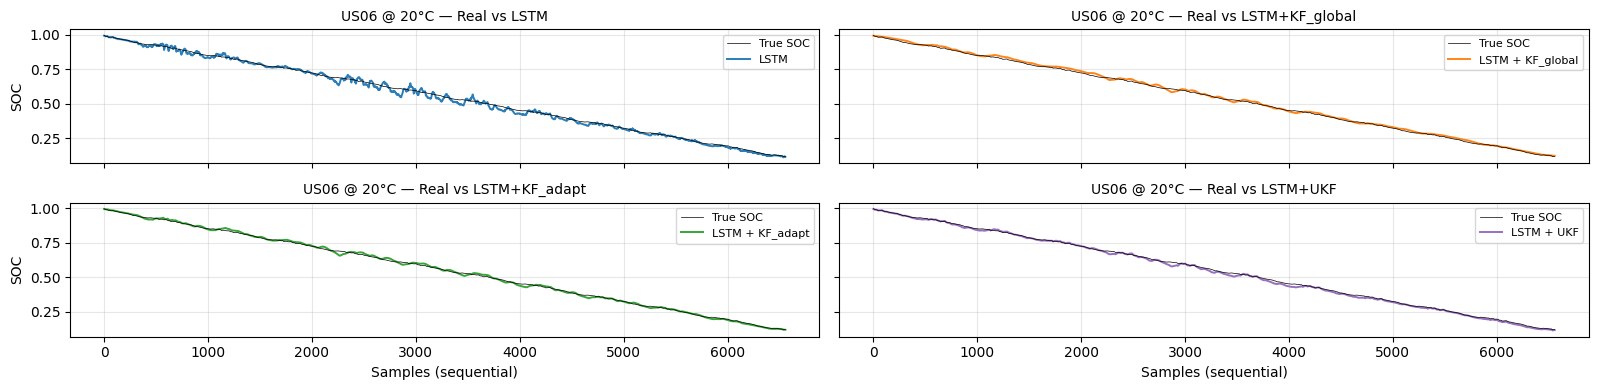

In [ ]:
# === 4 SUBPLOTS: Real vs LSTM / LSTM+KF_global / LSTM+KF_adapt / LSTM+UKF ===
import numpy as np
import matplotlib.pyplot as plt
import os

# ---- Cenário de teste ----
ciclo = "US06"
temp  = 20

# ---- Distinct colors ----
clr_true = "black"
clr_lstm = "#1f77b4"     # azul
clr_kfg  = "#ff7f0e"     # laranja
clr_kfa  = "#2ca02c"     # verde
clr_ukf  = "#9467bd"     # roxo

try:
    # 1) Carrega dados e janelas (nomes do seu código enxuto)
    arq = os.path.join(DATA_DIR, f"teste1_LSTM_{temp}.xlsx")
    df  = carregar_df(arq, ciclo)

    X_raw = x_scaler.transform(df[INPUT_COLS])
    y_raw = y_scaler.transform(df[[OUTPUT_COL]])
    X_seq, y_seq = criar_janelas_seq(X_raw, y_raw, TIME_STEP)

    # 2) Predição LSTM e inversão
    y_pred_scaled = model.predict(X_seq, verbose=0)
    y_pred_inv    = y_scaler.inverse_transform(y_pred_scaled).ravel()
    y_true_inv    = y_scaler.inverse_transform(y_seq).ravel()

    # 3) Corrente alinhada (UKF)
    I_full = df['Current(A)'].values.astype(float)
    I_seq  = I_full[TIME_STEP:TIME_STEP + len(y_true_inv)]

    # 4) STD globais Q/R
    if "q_global" not in globals() or "r_global" not in globals():
        raise ValueError("Defina q_global e r_global (standard deviations) no escopo.")
    q_std = float(q_global)
    r_std = float(r_global)

    # 5) KF Global
    if "kf_identity_fixed" not in globals():
        raise NameError("Função kf_identity_fixed não encontrada.")
    y_kf_global = kf_identity_fixed(y_pred_inv, q_std, r_std, P0=1.0, clip=True)

    # 6) KF Adaptativo
    if "kf_identity_adapt_R" not in globals():
        raise NameError("Function kf_identity_adapt_R not found.")
    adapt_alpha       = ADAPT_ALPHA       if "ADAPT_ALPHA"       in globals() else 0.01
    adapt_rmin_factor = ADAPT_RMIN_FACTOR if "ADAPT_RMIN_FACTOR" in globals() else 0.1
    adapt_rmax_factor = ADAPT_RMAX_FACTOR if "ADAPT_RMAX_FACTOR" in globals() else 10.0
    y_kf_adapt = kf_identity_adapt_R(
        y_pred_inv, q_std, r_std,
        alpha=adapt_alpha,
        R_min_factor=adapt_rmin_factor,
        R_max_factor=adapt_rmax_factor,
        P0=1.0, clip=True
    )

    # 7) UKF (opcional)
    y_ukf = None
    if "ukf_soc" in globals():
        if "gamma" in globals():
            gamma_val = float(gamma)
        else:
            # estima gamma por mínimos quadrados: ΔSOC ≈ gamma * I
            d_soc = np.diff(y_true_inv.astype(float))
            I_mid = I_seq[1:][:len(d_soc)]
            denom = float(np.dot(I_mid, I_mid))
            gamma_val = float(np.dot(I_mid, d_soc) / denom) if denom > 0 else 0.0
        Q = float(q_std**2)
        R = float(r_std**2)
        y_ukf = ukf_soc(current=I_seq, z_meas=y_pred_inv, gamma=gamma_val, Q=Q, R=R)

    # 8) Preparar figura 2×2 no MESMO tamanho total do gráfico antigo
    # (antes você usou ~ (16, 4); manteremos o total e distribuiremos em 4 subplots)
    fig, axes = plt.subplots(2, 2, figsize=(16, 4), sharex=True, sharey=True)
    axes = axes.ravel()

    x = np.arange(len(y_true_inv))

    def plot_duo(ax, y_true, y_est, label_est, col_est):
        ax.plot(x, y_true, label="True SOC", color=clr_true, linewidth=0.5, zorder=5)
        ax.plot(x, y_est, label=label_est, color=col_est, linewidth=1.4, alpha=0.95)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8, loc="best")

    # 1) Real vs LSTM
    plot_duo(axes[0], y_true_inv, y_pred_inv, "LSTM", clr_lstm)
    axes[0].set_title(f"{ciclo} @ {temp}°C — Real vs LSTM", fontsize=10)

    # 2) Real vs LSTM+KF_global
    plot_duo(axes[1], y_true_inv, y_kf_global, "LSTM + KF_global", clr_kfg)
    axes[1].set_title(f"{ciclo} @ {temp}°C — Real vs LSTM+KF_global", fontsize=10)

    # 3) Real vs LSTM+KF_adapt
    plot_duo(axes[2], y_true_inv, y_kf_adapt, "LSTM + KF_adapt", clr_kfa)
    axes[2].set_title(f"{ciclo} @ {temp}°C — Real vs LSTM+KF_adapt", fontsize=10)

    # 4) Real vs LSTM+UKF (ou aviso se não disponível)
    if y_ukf is not None:
        plot_duo(axes[3], y_true_inv, y_ukf, "LSTM + UKF", clr_ukf)
        axes[3].set_title(f"{ciclo} @ {temp}°C — Real vs LSTM+UKF", fontsize=10)
    else:
        axes[3].plot(x, y_true_inv, color=clr_true, linewidth=0.5, label="True SOC")
        axes[3].text(0.5, 0.5, "UKF não disponível", transform=axes[3].transAxes,
                     ha="center", va="center", fontsize=10)
        axes[3].grid(True, alpha=0.3)
        axes[3].legend(fontsize=8, loc="best")
        axes[3].set_title(f"{ciclo} @ {temp}°C — Real vs LSTM+UKF", fontsize=10)

    # Only outer labels on the borders to avoid clutter
    for ax in axes[2:]:
        ax.set_xlabel("Samples (sequential)")
    for ax in [axes[0], axes[2]]:
        ax.set_ylabel("SOC")

    plt.tight_layout()
    plt.show()

except Exception as exc:
    print(f"❌ Failed to generate the 4 subplots for {ciclo}@{temp}°C — {exc}")


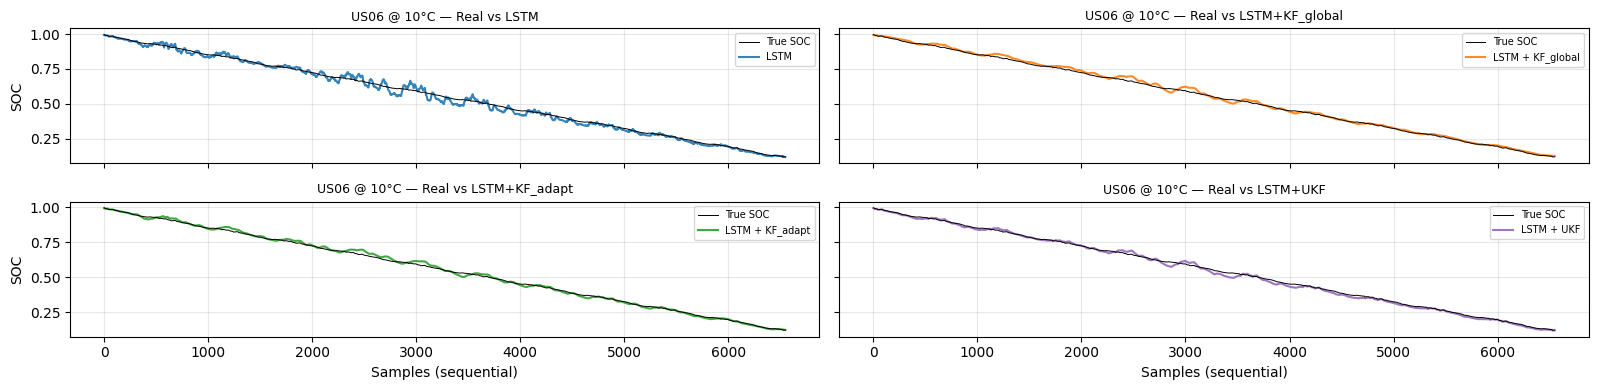

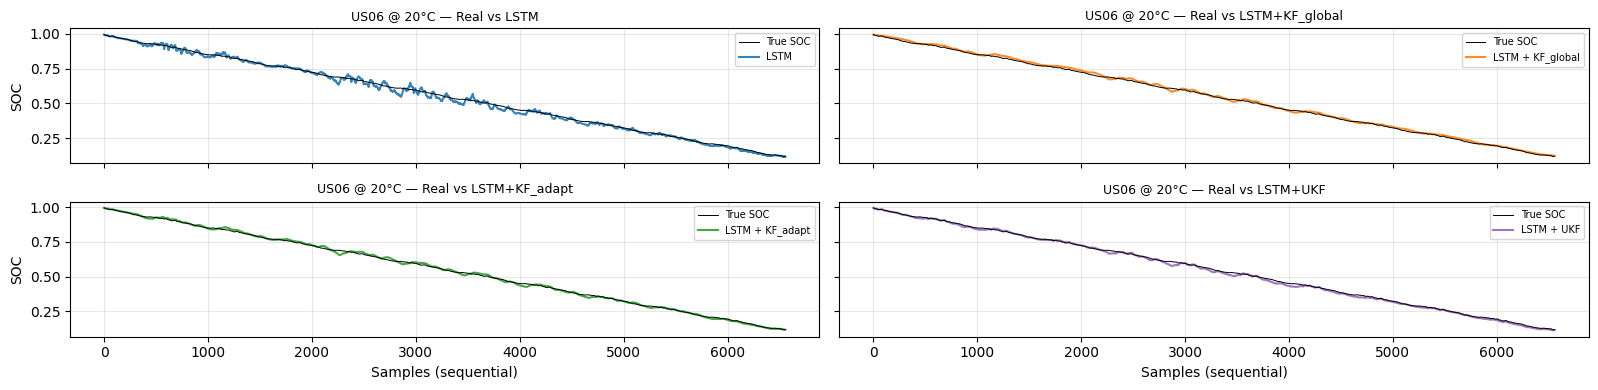

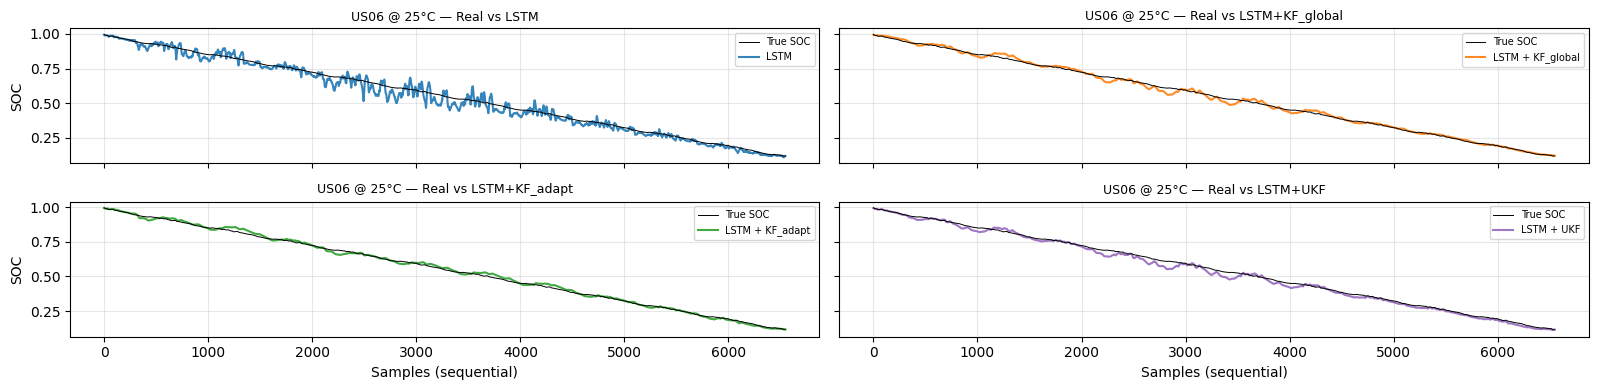

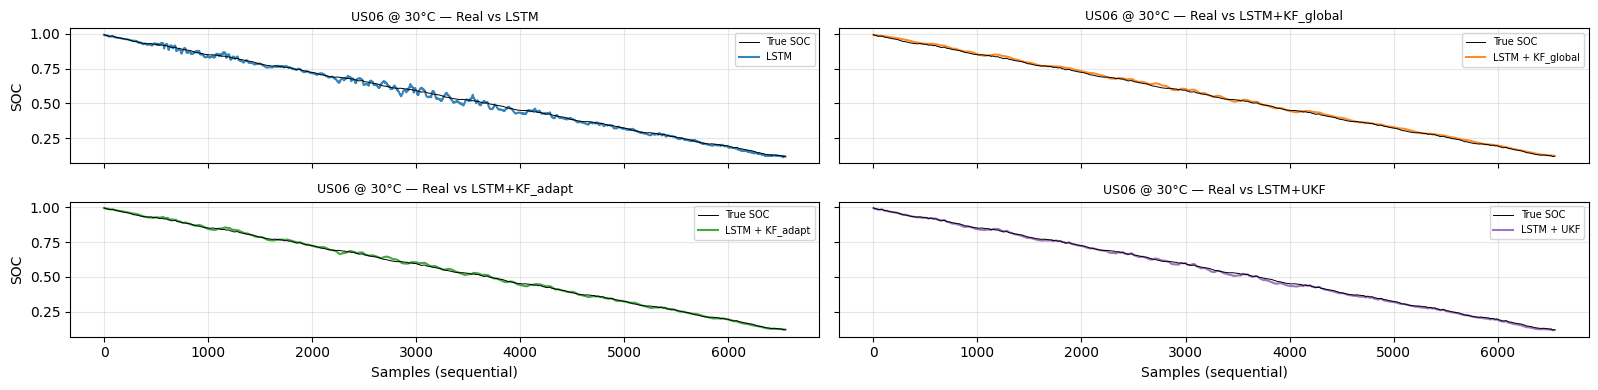

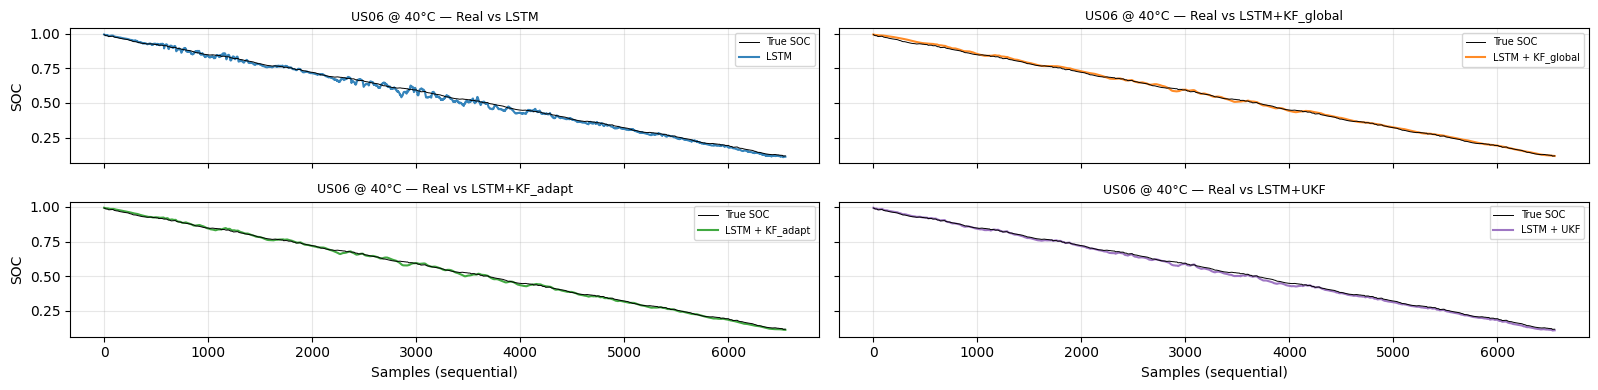

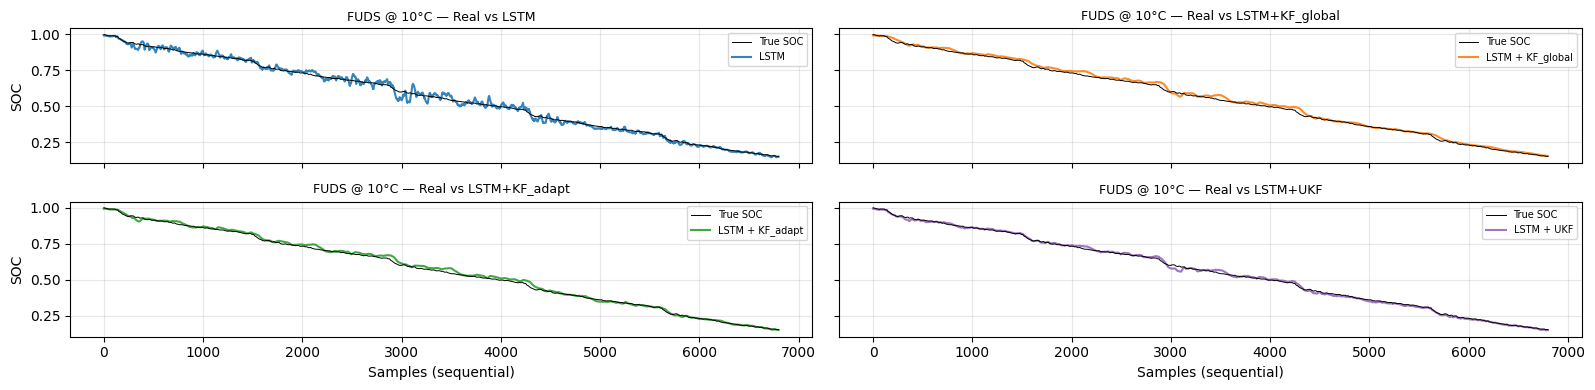

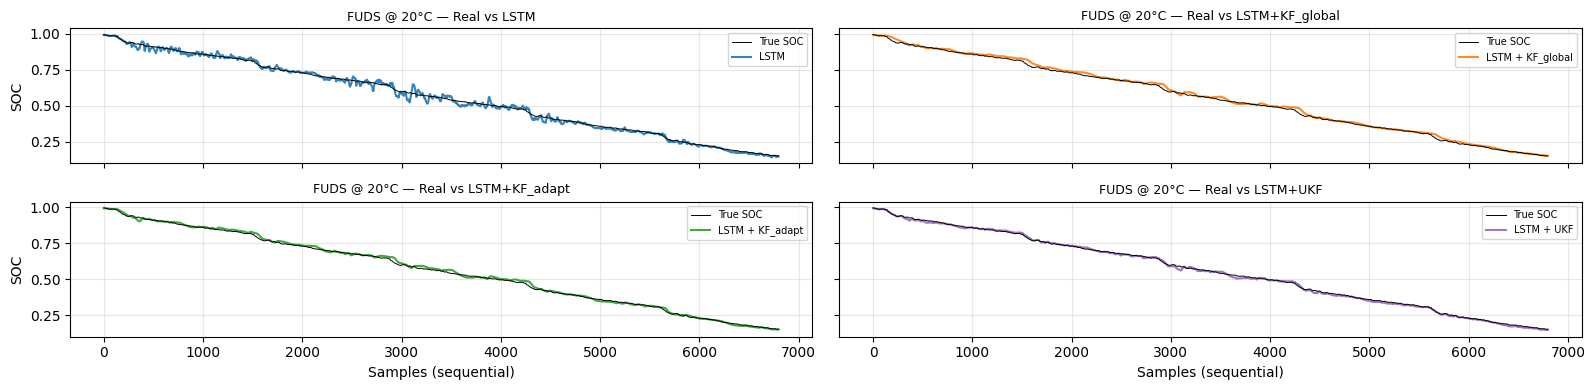

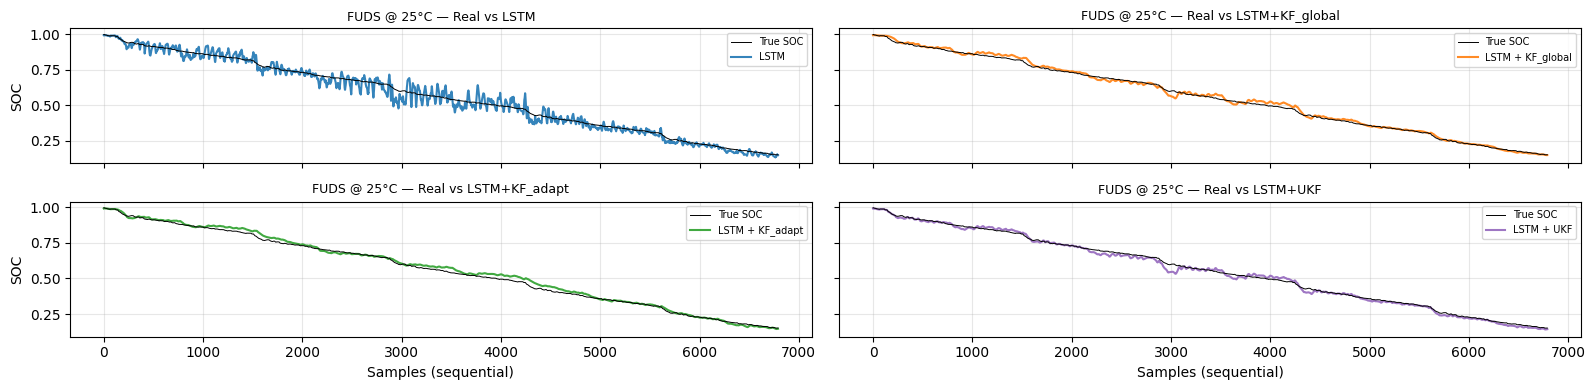

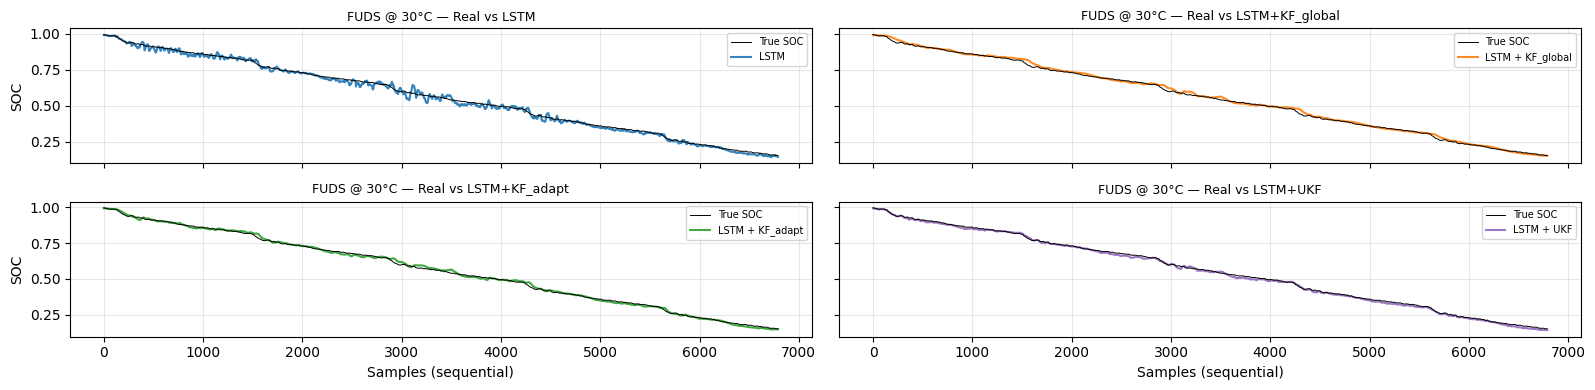

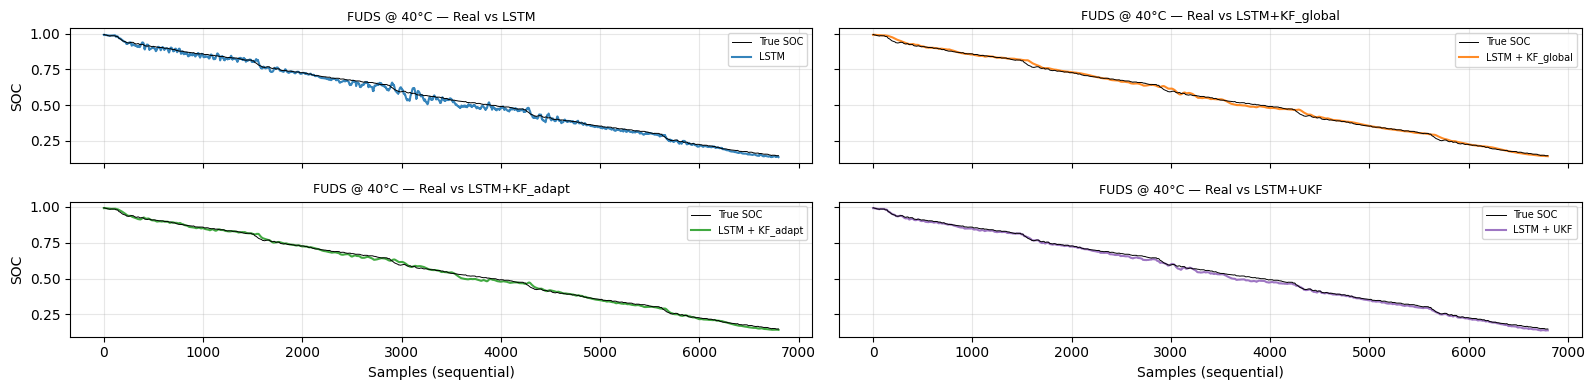

In [ ]:
# === 4 SUBPLOTS PARA TODOS OS CICLOS E TEMPERATURAS ===
import numpy as np
import matplotlib.pyplot as plt
import os

# ---- Cores ----
clr_true = "black"
clr_lstm = "#1f77b4"     # azul
clr_kfg  = "#ff7f0e"     # laranja
clr_kfa  = "#2ca02c"     # verde
clr_ukf  = "#9467bd"     # roxo

for ciclo in CICLOS:
    for temp in TEMPS:
        try:
            # --- Carrega dados e prepara janelas ---
            arq = os.path.join(DATA_DIR, f"teste1_LSTM_{temp}.xlsx")
            df  = carregar_df(arq, ciclo)

            X_raw = x_scaler.transform(df[INPUT_COLS])
            y_raw = y_scaler.transform(df[[OUTPUT_COL]])
            X_seq, y_seq = criar_janelas_seq(X_raw, y_raw, TIME_STEP)

            y_pred_scaled = model.predict(X_seq, verbose=0)
            y_pred_inv = y_scaler.inverse_transform(y_pred_scaled).ravel()
            y_true_inv = y_scaler.inverse_transform(y_seq).ravel()

            I_full = df['Current(A)'].values.astype(float)
            I_seq  = I_full[TIME_STEP:TIME_STEP + len(y_true_inv)]

            q_std = float(q_global)
            r_std = float(r_global)

            # --- KF Global ---
            y_kf_global = kf_identity_fixed(y_pred_inv, q_std, r_std, P0=1.0, clip=True)

            # --- KF Adaptativo ---
            adapt_alpha       = ADAPT_ALPHA       if "ADAPT_ALPHA"       in globals() else 0.01
            adapt_rmin_factor = ADAPT_RMIN_FACTOR if "ADAPT_RMIN_FACTOR" in globals() else 0.1
            adapt_rmax_factor = ADAPT_RMAX_FACTOR if "ADAPT_RMAX_FACTOR" in globals() else 10.0
            y_kf_adapt = kf_identity_adapt_R(y_pred_inv, q_std, r_std,
                                             alpha=adapt_alpha,
                                             R_min_factor=adapt_rmin_factor,
                                             R_max_factor=adapt_rmax_factor,
                                             P0=1.0, clip=True)

            # --- UKF (opcional) ---
            y_ukf = None
            if "ukf_soc" in globals():
                if "gamma" in globals():
                    gamma_val = float(gamma)
                else:
                    d_soc = np.diff(y_true_inv.astype(float))
                    I_mid = I_seq[1:][:len(d_soc)]
                    denom = float(np.dot(I_mid, I_mid))
                    gamma_val = float(np.dot(I_mid, d_soc) / denom) if denom > 0 else 0.0
                Q = float(q_std**2)
                R = float(r_std**2)
                y_ukf = ukf_soc(current=I_seq, z_meas=y_pred_inv, gamma=gamma_val, Q=Q, R=R)

            # --- Cria figura 2x2 ---
            fig, axes = plt.subplots(2, 2, figsize=(16, 4), sharex=True, sharey=True)
            axes = axes.ravel()
            x = np.arange(len(y_true_inv))

            def plot_duo(ax, y_true, y_est, label_est, col_est):
                ax.plot(x, y_true, label="True SOC", color=clr_true, linewidth=0.7, zorder=5)
                ax.plot(x, y_est,  label=label_est, color=col_est,  linewidth=1.5, alpha=0.9)
                ax.grid(True, alpha=0.3)
                ax.legend(fontsize=7, loc="best")

            plot_duo(axes[0], y_true_inv, y_pred_inv, "LSTM", clr_lstm)
            axes[0].set_title(f"{ciclo} @ {temp}°C — Real vs LSTM", fontsize=9)

            plot_duo(axes[1], y_true_inv, y_kf_global, "LSTM + KF_global", clr_kfg)
            axes[1].set_title(f"{ciclo} @ {temp}°C — Real vs LSTM+KF_global", fontsize=9)

            plot_duo(axes[2], y_true_inv, y_kf_adapt, "LSTM + KF_adapt", clr_kfa)
            axes[2].set_title(f"{ciclo} @ {temp}°C — Real vs LSTM+KF_adapt", fontsize=9)

            if y_ukf is not None:
                plot_duo(axes[3], y_true_inv, y_ukf, "LSTM + UKF", clr_ukf)
                axes[3].set_title(f"{ciclo} @ {temp}°C — Real vs LSTM+UKF", fontsize=9)
            else:
                axes[3].plot(x, y_true_inv, color=clr_true, linewidth=0.7, label="True SOC")
                axes[3].text(0.5, 0.5, "UKF não disponível", transform=axes[3].transAxes,
                             ha="center", va="center", fontsize=9)
                axes[3].grid(True, alpha=0.3)
                axes[3].legend(fontsize=7, loc="best")
                axes[3].set_title(f"{ciclo} @ {temp}°C — Real vs LSTM+UKF", fontsize=9)

            for ax in axes[2:]:
                ax.set_xlabel("Samples (sequential)")
            for ax in [axes[0], axes[2]]:
                ax.set_ylabel("SOC")

            plt.tight_layout()
            plt.show()

        except Exception as exc:
            print(f"❌ Failed in {ciclo}@{temp}°C — {exc}")
